In [33]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [34]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [35]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [36]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [37]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

In [38]:
test_file = 'bee_test.png'
image = load(test_file)

now prop
[BoxList(num_boxes=15, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=15, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
pb shap (100, 180)
peaks [[(62, 3, 0.25391424, 0), (117, 3, 1.1503628, 1), (62, 4, -1.3284522, 2), (42, 29, 0.14440411, 3), (42, 30, -0.85283244, 4), (58, 42, -0.69257534, 5), (47, 47, 2.1700702, 6), (62, 59, 0.2798344, 7), (62, 60, -1.213966, 8), (105, 64, -0.8158337, 9), (105, 65, -0.08442831, 10), (34, 71, 2.1024957, 11), (129, 75, 1.1995698, 12), (69, 78, 3.954967, 13), (142, 83, 0.5735954, 14)]]
62.0
117.0
62.0
42.0
42.0
58.0
47.0
62.0
62.0
105.0
105.0
34.0
129.0
69.0
142.0
now prop
[BoxList(num_boxes=0, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=0, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=0, image_width=2560, image_height=1440, mode=xyxy)
p

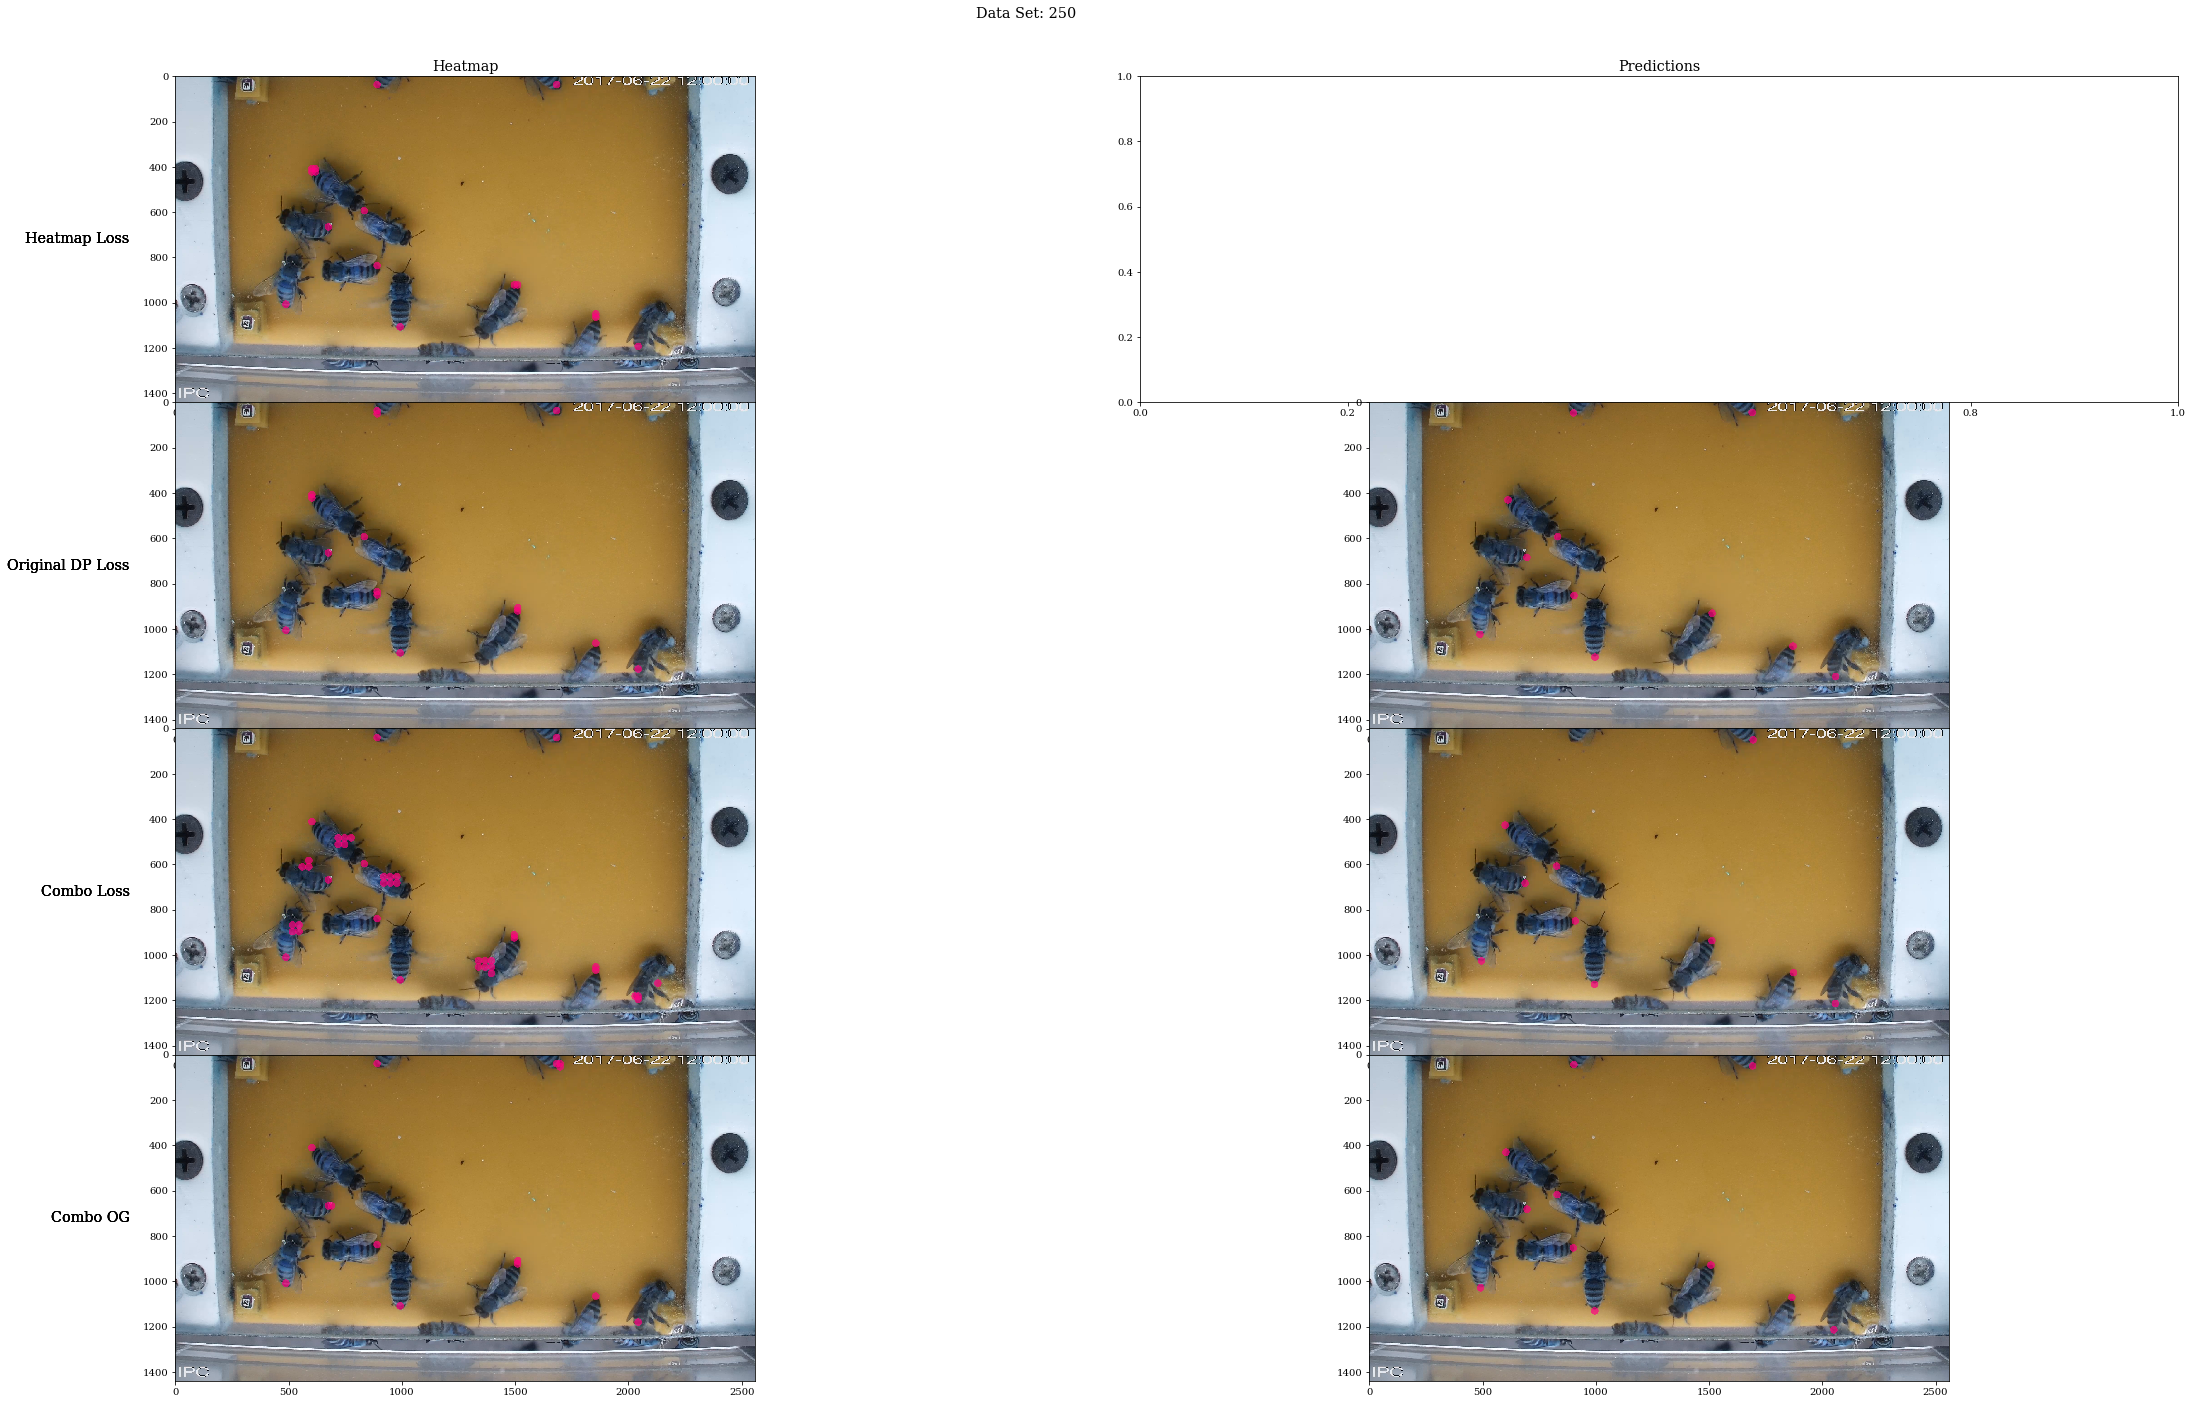

In [39]:
import matplotlib.gridspec as gridspec

pad = 5
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]#"DP Predictions", "Combined Heatmap", "Combined Pred"]
cols = ["Heatmap", "Predictions"]
data_sizes = ["250"]#, "50", "100"]
versions = ["0"]#, "1", "2", "3"]
losses = ["standard", "heatmap", "combined", "combined_og"]
for data_size in data_sizes:
    #plt.figure(figsize = (20,12))
    #gs1 = gridspec.GridSpec(3, 4)
    #gs1.update(wspace=0.025, hspace=0.05)
    fig, axes = plt.subplots(4,2,figsize=(40,24),constrained_layout=True,gridspec_kw = {'wspace':.15, 'hspace':0})
    fig.subplots_adjust(wspace=.15, hspace=.000001)
    #plt.gca().invert_yaxis()
    title = 'Data Set: ' + data_size
    fig.suptitle(title, y=.92)
    for col, version in enumerate(versions):
        for loss in losses:
            config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

            cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
            cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                             'DATATYPE', 'bee', \
                             'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/combined/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                             'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_final.pth',\
                             'DATASETS.TEST', "('bee_val_cocostyle',)",\
                             'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                            ])

            coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
            )

            # compute predictions
            predictions, tps, hm_res, stride, hms, targets = coco_demo.run_on_opencv_image(image)
            hms_tensor = hms.cpu().data.numpy() 
            data_temp = gaussian_filter(sigmoid_v(hms_tensor[0][0]), sigma=1.3)
            scale_factor = sigmoid_v(hms_tensor[0][0]).max()/data_temp.max()
            peaks = calculate_peaks(1, (hms_tensor[0]))
            #print("dim hm", hms_tensor)
            print('peaks', peaks)
            #print(np.shape(peaks[0])[0])
            #print("shap w", np.shape(hms_tensor))
            #print("shap imade", np.shape(image))
            #print("shap [][]", np.shape(hms_tensor[0][0]))
            
            hm_temp = torch.zeros(np.shape(peaks[0])[0], 5, 3)
            for ind, row in enumerate(peaks[0]):
                print(float(row[0]))
                hm_temp[ind][0][0] = float(row[0])*14.4
                hm_temp[ind][0][1] = float(row[1])*14.222222222222222
                hm_temp[ind][0][2] = sigmoid(float(row[2]))
            #print("hm_temp",hm_temp)
            
            im = overlay_keypoints(image, hm_temp)
            #imshow(newim)
            #f, a = plt.subplots(figsize=(18, 13))
            #a.imshow(newim, interpolation='nearest')
            #plt.tight_layout()
            #a.invert_yaxis()
            
            base_file = 'bee_' + data_size + '_' + version 
         
            cv2.imwrite(base_file + loss +".png", predictions[:, :, [2, 1, 0]])

            #fig, ax = plt.subplots(1,1,figsize=(12,8))
            
            if loss == "heatmap":
                #axes[0][col].set_title('min {:.2f} max {:.2f}'.format(data_temp.min(), data_temp.max()))
                #axes[0][col].set_title("Data Set " + version)
                #im = axes[0][col].imshow(data_temp, interpolation='none', vmin= data_temp.min(), vmax=data_temp.max())
                img1 = im
                #b,g,r = cv2.split(img2)       # get b,g,r
                #im = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[0][0].imshow(img1)
                axes[0][0].invert_yaxis()
                plt.savefig(base_file + '_hm.png')

            if loss == "standard":
                #axes[1][col].set_title('min {:.2f} max {:.2f}'.format(data_temp.min(), data_temp.max()))
                #im = axes[1][col].imshow(peaks, interpolation='none', vmin= data_temp.min(), vmax=data_temp.max())
                img1 = im
                #b,g,r = cv2.split(img2)       # get b,g,r
                #im = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[1][0].imshow(img1)
                axes[1][0].invert_yaxis()
    
                img2 = overlay_keypoints(image,tps.get_field("keypoints").keypoints)
                #b,g,r = cv2.split(img2)       # get b,g,r
                #img2 = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[1][1].imshow(img2)
                axes[1][1].invert_yaxis()
                plt.savefig(base_file + '_reg.png')
                
            if loss == "combined":
                #axes[1][col].set_title('min {:.2f} max {:.2f}'.format(data_temp.min(), data_temp.max()))
                #im = axes[1][col].imshow(peaks, interpolation='none', vmin= data_temp.min(), vmax=data_temp.max())
                img1 = im
                #b,g,r = cv2.split(img2)       # get b,g,r
                #im = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[2][0].imshow(img1)
                axes[2][0].invert_yaxis()
                
                img2 = overlay_keypoints(image,tps.get_field("keypoints").keypoints)
                #b,g,r = cv2.split(img2)       # get b,g,r
                #img2 = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[2][1].imshow(img2)
                axes[2][1].invert_yaxis()
                plt.savefig(base_file + '_com.png')
                
            if loss == "combined_og":
                #axes[1][col].set_title('min {:.2f} max {:.2f}'.format(data_temp.min(), data_temp.max()))
                #im = axes[1][col].imshow(peaks, interpolation='none', vmin= data_temp.min(), vmax=data_temp.max())
                img1 = im
                #b,g,r = cv2.split(img2)       # get b,g,r
                #im = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[3][0].imshow(img1)
                axes[3][0].invert_yaxis()
                
                img2 = overlay_keypoints(image,tps.get_field("keypoints").keypoints)
                #b,g,r = cv2.split(img2)       # get b,g,r
                #img2 = cv2.merge([r,g,b])     # switch it to rgb
                im = axes[3][1].imshow(img2)
                axes[3][1].invert_yaxis()
                plt.savefig(base_file + '_com.png')
                
            for ax, row in zip(axes[:,0], rows):
                ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

            #fig.show()
            #plt.pause(5)
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

    #cbar = fig.colorbar(im, ax=axes.flat)
    #fig.tight_layout()
    #fig.subplots_adjust(left=0.15, top=0.95, hspace=.000001)
    fig.subplots_adjust(wspace=.15, hspace=.01)
    #cbar = fig.colorbar(im, ax=axes.flat)
    fig.savefig('bee_all_' + data_size +'.png')
    plt.show()


1 of 8: 100/0/standard 

In [ ]:
sigmoid(0.37848875)